In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import psutil
import copy
import pickle
import re
from abc import ABC, abstractmethod
import math
import copy
from copy import deepcopy
from pathlib import Path
from skimage import data
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
import scipy
from scipy.special import softmax
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import skimage
import csv
import PIL
from skimage.filters import threshold_otsu
import torchvision.models as torchmodels
import openslide
import torch.utils.data
import torchvision
list_pathstoadd = ["../../", "../../../PyDmed/"]
for path in list_pathstoadd:
    if(path not in sys.path):
        sys.path.append(path)
import pydmed
from pydmed.utils.data import *
import pydmed.lightdl
from pydmed.lightdl import *
import pydmed.stat
from pydmed.stat import *
import localsrc_samplenotebooks
from localsrc_samplenotebooks import *
# import src_main_bow_classifier
# from src_main_bow_classifier import akRBFBoVW, akAvgPerWSI, BoVW_Model

In [2]:
#settings ====================
numepochs_stage1 = 96001
flag_use_annotregions = False
npseed = 15
num_visualwords = 10

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
tstart_notebook = time.time()

cuda:0


In [4]:
#load datasets ======================
file_dataset = open("Trained_Models/test_dataset.pkl", 'rb')
pkl_datasets = pickle.load(file_dataset)
file_dataset.close()
recscore_dataset = pkl_datasets["recscore_dataset"]
train_ds = pkl_datasets["train_ds"]
val_ds = pkl_datasets["val_ds"]
test_ds = pkl_datasets["test_ds"]
batchsize = pkl_datasets["batchsize"]
num_visualwords = pkl_datasets["num_visualwords"]
#load model ===========================
model = SamplePipeline1(num_classes=2, num_visualwords=num_visualwords,\
                        device_stg3=device, size_input=[batchsize,3,224,224]) 


model.load_state_dict(torch.load("Trained_Models/test_model.pt"))
model.eval()
print("model loaded from file.")

model loaded from file.


In [5]:
#precompute otsu-foreground for all patients =============
def otsu_get_foregroundmask(fname_wsi, scale_thumbnail):
    #settings =======
#     scale_thumbnail =  0.01
    width_targetpatch = 5000 
    #extract the foreground =========================
    osimage = openslide.OpenSlide(fname_wsi)
    W, H = osimage.dimensions
    size_thumbnail = (int(scale_thumbnail*W), int(scale_thumbnail*H))
    pil_thumbnail = osimage.get_thumbnail(size_thumbnail)
    np_thumbnail = np.array(pil_thumbnail)
    np_thumbnail = np_thumbnail[:,:,0:3]
    np_thumbnail = rgb2gray(np_thumbnail)
    thresh = threshold_otsu(np_thumbnail)
    background = (np_thumbnail > thresh) + 0.0
    foreground = 1.0 - background
    w_padding_of_thumbnail = int(width_targetpatch * scale_thumbnail)
    foreground[0:w_padding_of_thumbnail, :] = 0
    foreground[-w_padding_of_thumbnail::, :] = 0
    foreground[: , 0:w_padding_of_thumbnail] = 0
    foreground[: , -w_padding_of_thumbnail::] = 0
    return foreground

scale_thumbnail =  0.005
tstart_otsu = time.time()
dict_patient_to_foreground = {}
for idx_patient, patient in enumerate(recscore_dataset.list_patients):
    print(" computing foreground for patient {}".format(idx_patient))
    fname_wsi = os.path.join(patient.dict_records["wsi"].rootdir,\
                             patient.dict_records["wsi"].relativedir)
    patient_foreground_mask =\
        otsu_get_foregroundmask(fname_wsi, scale_thumbnail)
    patient.dict_records["foreground_mask"] = patient_foreground_mask
    patient.dict_records["scale_thumbnail"] = scale_thumbnail
tend_otsu = time.time()
print("elapsed time = {}".format(tend_otsu - tstart_otsu))

 computing foreground for patient 0
 computing foreground for patient 1
 computing foreground for patient 2
 computing foreground for patient 3
 computing foreground for patient 4
 computing foreground for patient 5
 computing foreground for patient 6
 computing foreground for patient 7
 computing foreground for patient 8
 computing foreground for patient 9
 computing foreground for patient 10
 computing foreground for patient 11
 computing foreground for patient 12
 computing foreground for patient 13
 computing foreground for patient 14
 computing foreground for patient 15
 computing foreground for patient 16
 computing foreground for patient 17
 computing foreground for patient 18
 computing foreground for patient 19
 computing foreground for patient 20
 computing foreground for patient 21
 computing foreground for patient 22
 computing foreground for patient 23
 computing foreground for patient 24
 computing foreground for patient 25
 computing foreground for patient 26
 computing 

 computing foreground for patient 219
 computing foreground for patient 220
 computing foreground for patient 221
 computing foreground for patient 222
 computing foreground for patient 223
 computing foreground for patient 224
 computing foreground for patient 225
 computing foreground for patient 226
 computing foreground for patient 227
 computing foreground for patient 228
 computing foreground for patient 229
 computing foreground for patient 230
 computing foreground for patient 231
 computing foreground for patient 232
 computing foreground for patient 233
 computing foreground for patient 234
 computing foreground for patient 235
 computing foreground for patient 236
 computing foreground for patient 237
 computing foreground for patient 238
 computing foreground for patient 239
 computing foreground for patient 240
 computing foreground for patient 241
 computing foreground for patient 242
 computing foreground for patient 243
 computing foreground for patient 244
 computing f

In [6]:
def otsu_getpoint_from_foreground(fname_wsi, num_returned_points, patient):
    #settings =======
    scale_thumbnail =  patient.dict_records["scale_thumbnail"]
    foreground = patient.dict_records["foreground_mask"]
    #select a random point =========================
    one_indices = np.where(foreground==1.0)
    i_oneindices, j_oneindices = one_indices[0].tolist(), one_indices[1].tolist()
    n = random.choices(range(len(i_oneindices)), k=num_returned_points)
    i_oneindices, j_oneindices = np.array(i_oneindices), np.array(j_oneindices)
    i_selected, j_selected = i_oneindices[n], j_oneindices[n]
    i_selected, j_selected = np.array(i_selected), np.array(j_selected)
    #     assert(foreground[i_selected, j_selected] == 1)
    i_selected_realscale, j_selected_realscale =\
        (i_selected/scale_thumbnail).astype(np.int), (j_selected/scale_thumbnail).astype(np.int)
    x, y = list(j_selected_realscale), list(i_selected_realscale)
    return x,y 
    
class WSIRandomBigchunkLoader(BigChunkLoader):
    @abstractmethod
    def extract_bigchunk(self, last_message_fromroot):
        '''
        Extract and return a bigchunk. 
        Please note that in this function you have access to
        self.patient and self.const_global_info.
        '''
        list_bigchunks = []
        num_bigpatches = 5
        
        #preselect `num_bigpatches` random points on foreground.
        wsi = self.patient.dict_records["wsi"]
        fname_wsi = wsi.rootdir + wsi.relativedir
        all_randx, all_randy = \
            otsu_getpoint_from_foreground(fname_wsi, num_bigpatches, self.patient)
        
        for idx_bigpatch in range(num_bigpatches): #TODO:make tunable
            #settings ==== 
            flag_use_otsu = True
            #===
            wsi = self.patient.dict_records["wsi"]
            fname_wsi = wsi.rootdir + wsi.relativedir
            osimage = openslide.OpenSlide(fname_wsi)
            w, h = self.const_global_info["width_bigchunk"],\
                   self.const_global_info["heigth_bigchunk"] 
            W, H = osimage.dimensions
            if((flag_use_otsu == True) and (flag_use_annotregions==False)):
                rand_x, rand_y = all_randx[idx_bigpatch],\
                                 all_randy[idx_bigpatch]
                rand_x, rand_y = int(rand_x-(w*0.5)), int(rand_y-(h*0.5))
            elif(flag_use_annotregions == True):
                list_polygons = self.patient.dict_records["list_polygons"]
                if(list_polygons == None):
                    #there is no annotation for the patient
                    rand_x, rand_y = np.random.randint(0, W-w), np.random.randint(0, H-h)
                else:
                    polygon = random.choice(list_polygons)
                    sly_polygon = Polygon(polygon)
                    rand_point = random_points_within_polyg(sly_polygon, 1)[0]
                    rand_x, rand_y = rand_point.x, rand_point.y
                    rand_x, rand_y = float(rand_x), float(rand_y)
                    rand_x, rand_y = rand_x-w*0.5, rand_y-h*0.5 #convert center to topleft
                    rand_x, rand_y = int(rand_x), int(rand_y)
            pil_bigchunk = osimage.read_region([rand_x, rand_y], 1, [w,h])
            np_bigchunk = np.array(pil_bigchunk)[:,:,0:3]
            patient_without_foregroundmask = copy.deepcopy(self.patient)
            patient_without_foregroundmask.dict_records["foreground_mask"] = None
            bigchunk = BigChunk(data=np_bigchunk,\
                                 dict_info_of_bigchunk={"x":rand_x, "y":rand_y},\
                                 patient=patient_without_foregroundmask)
            #log to logfile
            self.log("new bigchunk with [left,top] = [{} , {}]\n".\
                     format(rand_x, rand_y))
            list_bigchunks.append(bigchunk)
        return list_bigchunks

class WSIRandomSmallchunkCollector(SmallChunkCollector):
    def __init__(self, *args, **kwargs):
        #grab privates
        self.tfms_onsmallchunkcollection =\
            torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),\
            torchvision.transforms.ToTensor(),\
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],\
                                             std=[0.229, 0.224, 0.225])
        ])
        super(WSIRandomSmallchunkCollector, self).__init__(*args, **kwargs)
    
    
    @abstractmethod     
    def extract_smallchunk(self, call_count, list_bigchunks, last_message_fromroot):
        '''
        Extract and return a smallchunk. Please note that in this function you have access to 
        self.bigchunk, self.patient, self.const_global_info.
        Inputs:
            - list_bigchunks: the list of extracted bigchunks.
        '''"list_polygons"
        #Note:balancestats =====
        #MAXNUM_STATS
        if(call_count>=100):
            return None
        
        bigchunk = random.choice(list_bigchunks)
        W, H = bigchunk.data.shape[1], bigchunk.data.shape[0]
        w, h = self.const_global_info["width_smallchunk"],\
               self.const_global_info["heigth_smallchunk"]
        rand_x, rand_y = np.random.randint(0, W-w), np.random.randint(0, H-h)
        np_smallchunk = bigchunk.data[rand_y:rand_y+h, rand_x:rand_x+w, :]
        #apply the transformation ===========
        if(self.tfms_onsmallchunkcollection != None):
            toret = self.tfms_onsmallchunkcollection(np_smallchunk)
            toret = toret.cpu().detach().numpy() #[3 x 224 x 224]
            toret = np.transpose(toret, [1,2,0]) #[224 x 224 x 3]
        else:
            toret = np_smallchunk
        #wrap in SmallChunk
        smallchunk = SmallChunk(data=np_smallchunk,\
                                dict_info_of_smallchunk={"x":rand_x, "y":rand_y},\
                                dict_info_of_bigchunk = bigchunk.dict_info_of_bigchunk,\
                                patient=bigchunk.patient)
        return smallchunk
    
def visualize_one_patient(patient, list_smallchunks):
    '''
    Given all smallchunks collected for a specific patient, this function
    should visualize the patient. 
    Inputs:
        - patient: the patient under considerations, an instance of `utils.data.Patient`.
        - list_smallchunks: the list of all collected small chunks for the patient,
            a list whose elements are an instance of `lightdl.SmallChunk`.
    '''
    #settings =======
    scale_2 = 0.1 #=====
    fname_wsi = patient.dict_records["wsi"].rootdir + patient.dict_records["wsi"].relativedir
    opsimage = openslide.OpenSlide(fname_wsi)
    scale_1 = 1.0/opsimage.level_downsamples[1]
    W, H = opsimage.dimensions
    opsimageW, opsimageH = opsimage.dimensions
    W, H = int(W*scale_1*scale_2), int(H*scale_1*scale_2)
    pil_thumbnail = opsimage.get_thumbnail((W,H))
    plt.ioff()
    fig, ax = plt.subplots(1,2, figsize=(2*10,10))
    ax[0].imshow(pil_thumbnail)
    ax[0].axis('off')
    ax[0].set_title("patient {}, H&E [{} x {}]."\
                    .format(patient.int_uniqueid, opsimageW, opsimageH))
    ax = ax[1]
    ax.imshow(pil_thumbnail)
    ax.axis('off')
    print("patient {}, number of smallchunks={}"\
          .format(patient, len(list_smallchunks)))
    list_colors = ['lawngreen', 'cyan', 'gold', 'greenyellow']
    list_shownbigchunks = []
    for smallchunk in list_smallchunks:
        #show the bigchunk ================
        x = smallchunk.dict_info_of_bigchunk["x"]
        y = smallchunk.dict_info_of_bigchunk["y"]
        x, y = int(x*scale_1*scale_2), int(y*scale_1*scale_2)
        if(not([x,y] in list_shownbigchunks)):
            w, h = int(4000*scale_1*scale_2), int(4000*scale_1*scale_2)
            rect = patches.Rectangle((x,y), w, h, linewidth=1,\
                                      linestyle="--",\
                                      edgecolor=random.choice(list_colors),\
                                      facecolor='none', fill=False)
            ax.add_patch(rect)
            list_shownbigchunks.append([x,y])
        
        #get x,y,w,h ======
        x = smallchunk.dict_info_of_smallchunk["x"]*scale_2 +\
            smallchunk.dict_info_of_bigchunk["x"]*scale_1*scale_2
        y = smallchunk.dict_info_of_smallchunk["y"]*scale_2 +\
            smallchunk.dict_info_of_bigchunk["y"]*scale_1*scale_2
        x, y = int(x), int(y)
        w, h = int(224*4*scale_1*scale_2), int(224*4*scale_1*scale_2)
        x_centre, y_centre = int(x+0.5*w), int(y+0.5*h)
        #make-show the rect =====
        circle = patches.Circle((x_centre, y_centre), radius=w*0.05,\
                                 facecolor=random.choice(list_colors),\
                                 fill=True)
        ax.add_patch(circle)
    #show the annotations (if the patient has annotations) =========
    if(flag_use_annotregions == True):
        list_polygons = patient.dict_records["list_polygons"]
        if(list_polygons != None):
            for polygon in list_polygons:
                polygon = np.array(polygon) * scale_1*scale_2
                plt_polygon = patches.Polygon(polygon, facecolor='none', fill=False,\
                                              edgecolor="r", linestyle="-", linewidth=4)
                ax.add_patch(plt_polygon)
    plt.title("patient {} (extracted big/small chunks) \n file:{}"\
              .format(patient.int_uniqueid,
                      patient.dict_records["wsi"].relativedir), fontsize=20)
    plt.savefig("Visualization/LightDL/Training/patient_{}.eps"\
                .format(patient.int_uniqueid), bbox_inches='tight',  format='eps')
    plt.close(fig)

# Make the Concrete StatCollector

In [7]:
class BoVWStatCollector(StatCollector):
    def __init__(self, module_pipeline, device, *args, **kwargs):
        #grab privates
        self.module_pipeline = module_pipeline
        self.device = device
        #make other initial operations
        self.module_pipeline.to(device)
        self.module_pipeline.eval()
        self.num_calls_to_getflagfinished = 0
        super(BoVWStatCollector, self).__init__(*args, **kwargs)
        
    @abstractmethod
    def get_statistics(self, retval_collatefunc):
        x, list_patients, list_smallchunks = retval_collatefunc
        with torch.no_grad():
            netout = self.module_pipeline.testingtime_forward(x.to(device))#[32x100x7x7]
            netout = netout.cpu().numpy() #[32x100x7x7]
        list_statistics = []
        list_statistics += [Statistic(
                                stat=netout[n,:,:,:],\
                                source_smallchunk = list_smallchunks[n]
                              )
                             for n in range(netout.shape[0])]
        return list_statistics
    
    
    @abstractmethod
    def accum_statistics(self, prev_accum, new_stat, patient):
        if(prev_accum == None):
            #the first stat ====
            toret = {"count":1, "sum_encoded_descriptors": new_stat.stat}
        else:
            #not the first stat ====
            old_count, old_sum = prev_accum["count"], prev_accum["sum_encoded_descriptors"]
            MAXNUM_STATS = 500
            if(old_count < MAXNUM_STATS):
                toret = {"count": old_count+1,\
                         "sum_encoded_descriptors": old_sum + new_stat.stat}
            else:
                toret = {"count": old_count,\
                         "sum_encoded_descriptors": old_sum}
        return toret
                                 
    
    @abstractmethod
    def get_flag_finishcollecting(self):
        self.num_calls_to_getflagfinished += 1
        print("self.num_calls_to_getflagfinished = {}\n"\
                  .format(self.num_calls_to_getflagfinished))
        list_statcount = []
        for patient in self.dict_patient_to_accumstat.keys():
            if(self.dict_patient_to_accumstat[patient] != None):
                list_statcount.append(self.dict_patient_to_accumstat[patient]["count"])
            else:
                list_statcount.append(0)
        print(" numstats in [{} , {}],     num zeros = {}"
              .format(min(list_statcount) , max(list_statcount),
                      np.sum(np.array(list_statcount) == 0)) )
        #show bar of num-stats ====
        plt.figure()
        plt.bar(range(len(list_statcount)), list_statcount)
        plt.xticks(range(len(list_statcount)), rotation='vertical')
        plt.xlabel("index of patient")
        plt.ylabel("number of collected stats.")
        plt.show()
        MAXNUM_STATS = 500
        if((min(list_statcount)==MAXNUM_STATS) and (max(list_statcount)==MAXNUM_STATS)):
            if(True):#self.num_calls_to_getflagfinished > 100):
                return True
        else:
            return False
    

# Make the Scheduler In-Turn

In [8]:
class DLWithInTurnSched(LightDL):
    def __init__(self, *args, **kwargs):
        self.list_active_subclass = [] #push to left, pop from right
        self.list_waiting_subclass = []#push to right, pop from left
        self.sched_count_subclass = 0
        super(DLWithInTurnSched, self).__init__(*args, **kwargs)
    
    def schedule(self):
        '''
        This function is called when schedulling a new patient, i.e., loading a new BigChunk.
        This function has to return:
            - patient_toremove: the patient to remove, an instance of `utils.data.Patient`.
            - patient_toload: the patient to load, an instance of `utils.data.Patient`.
        In this function, you have access to the following fields:
            - self.dict_patient_to_schedcount: given a patient, returns the number of times the patients has been schedulled in dl, a dictionary.
            - self.list_loadedpatients:
            - self.list_waitingpatients:
            - TODO: add more fields here to provide more flexibility. For instance, total time that the patient have been loaded on DL.
        '''
        self.sched_count_subclass += 1
        #get initial fields ==============================
        list_loadedpatients = self.get_list_loadedpatients()
        list_waitingpatients = self.get_list_waitingpatients()
        waitingpatients_schedcount = [self.get_schedcount_of(patient)\
                                      for patient in list_waitingpatients]
        if(self.list_active_subclass == []):
            #the first call to `schedule function`
            self.list_active_subclass = list_loadedpatients
            self.list_waiting_subclass = list_waitingpatients
        #patient_toremove =======================
        patient_toremove = self.list_active_subclass[-1]
        #patient toadd ================
        patient_toload = self.list_waiting_subclass[0]
        #update the two in-turn lists
        self.list_active_subclass = [patient_toload] + self.list_active_subclass[0:-1]
        self.list_waiting_subclass = self.list_waiting_subclass[1::] + [patient_toremove]
        return patient_toremove, patient_toload
    

In [9]:
tfms = torchvision.transforms.ToTensor()
const_global_info = {
    "width_bigchunk":2000,
    "heigth_bigchunk":2000,
    "width_smallchunk":224*2,
    "heigth_smallchunk":224*2,
    "num_bigchunkloaders":10,
    "maxlength_queue_smallchunk":100,
    "maxlength_queue_lightdl":10000,
    "interval_resched": 5,
    "core-assignment":{"lightdl":None,
                       "smallchunkloaders":None,
                       "bigchunkloaders":None}
}
#TODO:change the dataset from val_ds to test_ds or whole_dataset
dl_of_statcollector = DLWithInTurnSched(
                              dataset=val_ds,\
                              type_bigchunkloader=WSIRandomBigchunkLoader,\
                              type_smallchunkcollector=WSIRandomSmallchunkCollector,\
                              const_global_info=const_global_info,\
                              batch_size=64, tfms=tfms,\
                              flag_grabqueue_onunsched = False
                           ) 
statcollector = BoVWStatCollector(module_pipeline=model, device=device,\
                                lightdl=dl_of_statcollector,\
                                str_collectortype = "accum",\
                                flag_visualizestats=False)
print("statcollector created.")

statcollector created.


 loading initial bigchunks, please wait ....
     bigchunk 0 from 10, please wait ...

     bigchunk 1 from 10, please wait ...

     bigchunk 2 from 10, please wait ...

     bigchunk 3 from 10, please wait ...

     bigchunk 4 from 10, please wait ...

     bigchunk 5 from 10, please wait ...

     bigchunk 6 from 10, please wait ...

     bigchunk 7 from 10, please wait ...

     bigchunk 8 from 10, please wait ...

     bigchunk 9 from 10, please wait ...

The initial loading of bigchunks took 60.9280207157135 seconds.
self.num_calls_to_getflagfinished = 1

 numstats in [0 , 7],     num zeros = 16


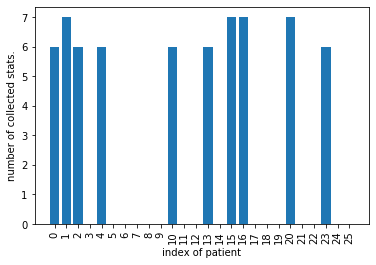

self.num_calls_to_getflagfinished = 2

 numstats in [0 , 61],     num zeros = 16


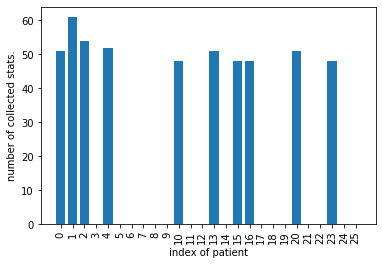

 got 10 stats
self.num_calls_to_getflagfinished = 3

 numstats in [0 , 100],     num zeros = 16


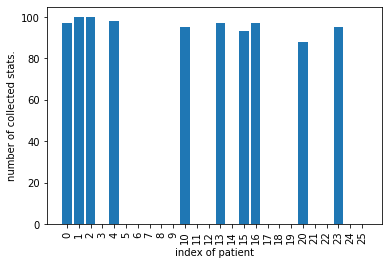

self.num_calls_to_getflagfinished = 4

 numstats in [0 , 100],     num zeros = 15


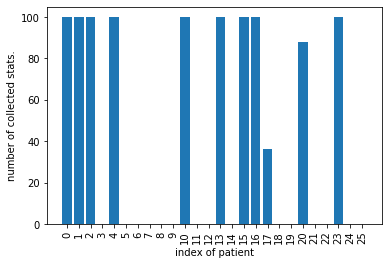

self.num_calls_to_getflagfinished = 5

 numstats in [0 , 100],     num zeros = 14


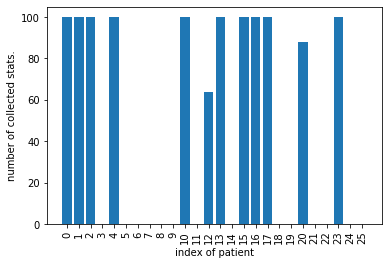

self.num_calls_to_getflagfinished = 6

 numstats in [0 , 100],     num zeros = 13


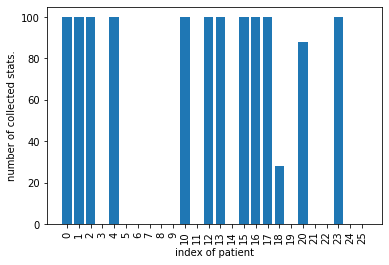

 got 20 stats
self.num_calls_to_getflagfinished = 7

 numstats in [0 , 100],     num zeros = 11


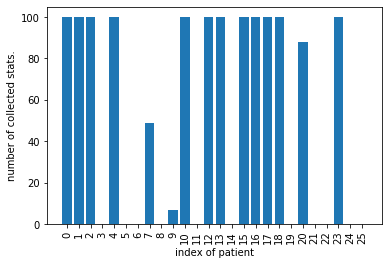

self.num_calls_to_getflagfinished = 8

 numstats in [0 , 100],     num zeros = 10


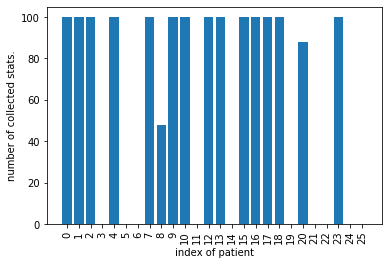

self.num_calls_to_getflagfinished = 9

 numstats in [0 , 100],     num zeros = 9


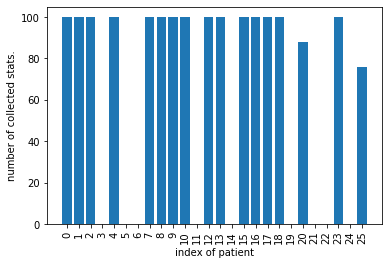

self.num_calls_to_getflagfinished = 10

 numstats in [0 , 100],     num zeros = 7


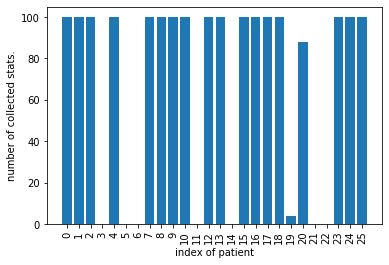

 got 30 stats
self.num_calls_to_getflagfinished = 11

 numstats in [0 , 100],     num zeros = 6


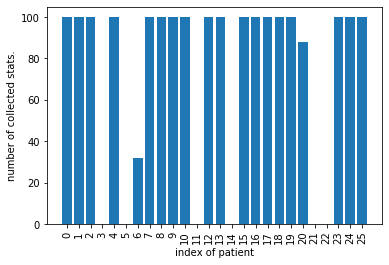

self.num_calls_to_getflagfinished = 12

 numstats in [0 , 100],     num zeros = 5


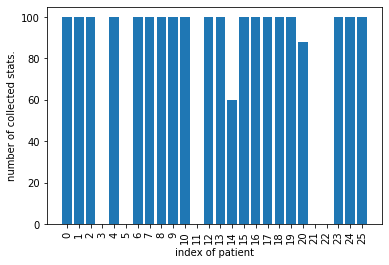

self.num_calls_to_getflagfinished = 13

 numstats in [0 , 100],     num zeros = 4


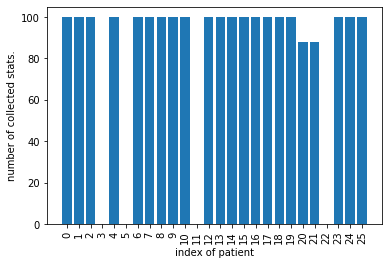

self.num_calls_to_getflagfinished = 14

 numstats in [0 , 100],     num zeros = 2


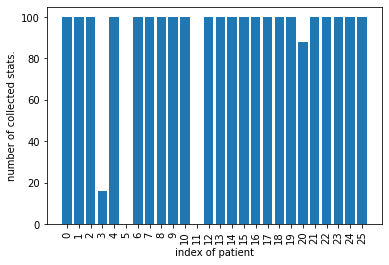

self.num_calls_to_getflagfinished = 15

 numstats in [19 , 100],     num zeros = 0


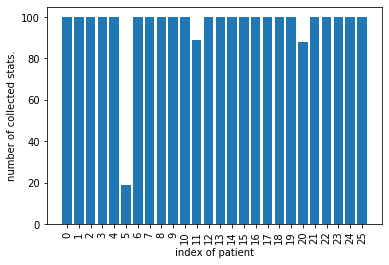

 got 40 stats
self.num_calls_to_getflagfinished = 16

 numstats in [100 , 124],     num zeros = 0


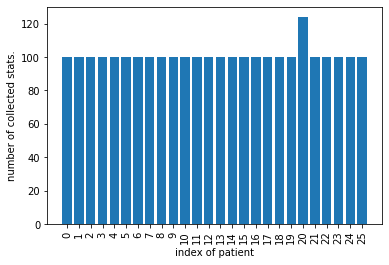

self.num_calls_to_getflagfinished = 17

 numstats in [100 , 188],     num zeros = 0


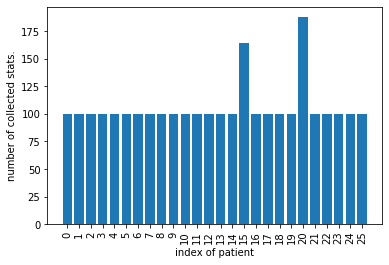

self.num_calls_to_getflagfinished = 18

 numstats in [100 , 200],     num zeros = 0


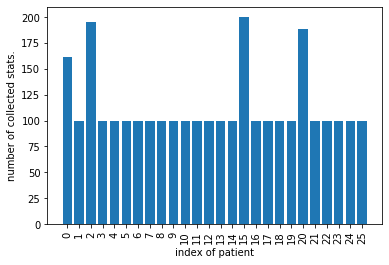

self.num_calls_to_getflagfinished = 19

 numstats in [100 , 200],     num zeros = 0


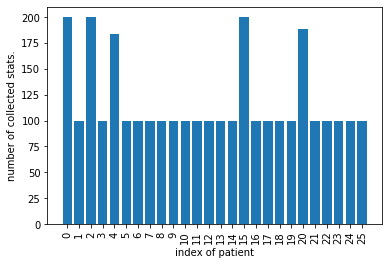

self.num_calls_to_getflagfinished = 20

 numstats in [100 , 200],     num zeros = 0


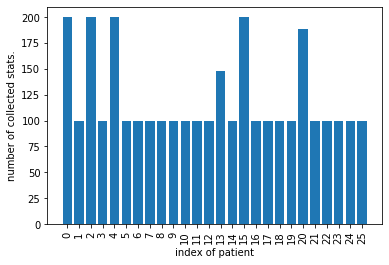

 got 50 stats
self.num_calls_to_getflagfinished = 21

 numstats in [100 , 200],     num zeros = 0


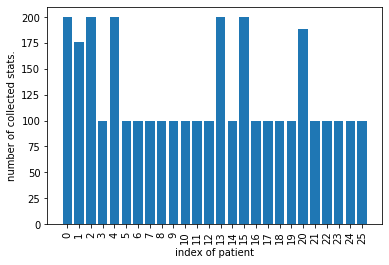

self.num_calls_to_getflagfinished = 22

 numstats in [100 , 200],     num zeros = 0


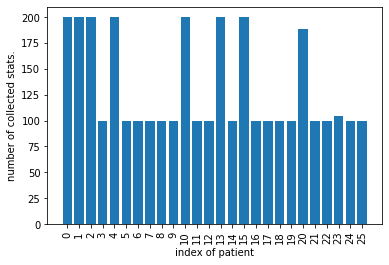

self.num_calls_to_getflagfinished = 23

 numstats in [100 , 200],     num zeros = 0


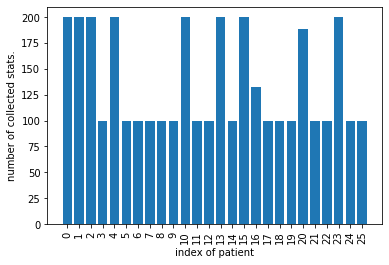

self.num_calls_to_getflagfinished = 24

 numstats in [100 , 200],     num zeros = 0


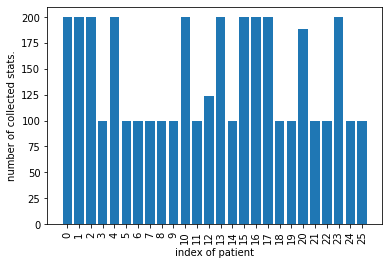

 got 60 stats
self.num_calls_to_getflagfinished = 25

 numstats in [100 , 200],     num zeros = 0


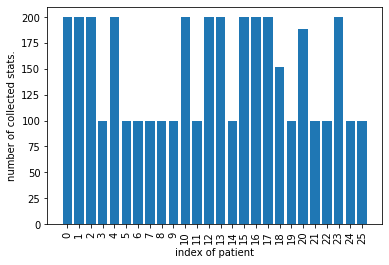

self.num_calls_to_getflagfinished = 26

 numstats in [100 , 200],     num zeros = 0


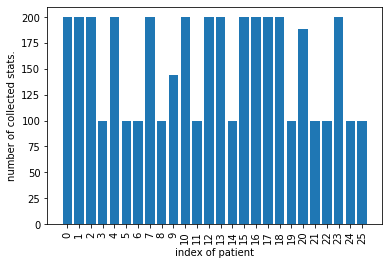

self.num_calls_to_getflagfinished = 27

 numstats in [100 , 200],     num zeros = 0


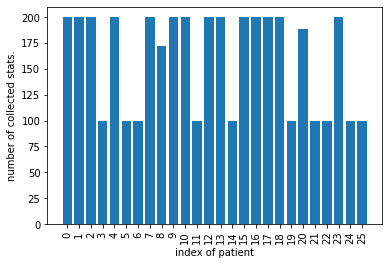

self.num_calls_to_getflagfinished = 28

 numstats in [100 , 200],     num zeros = 0


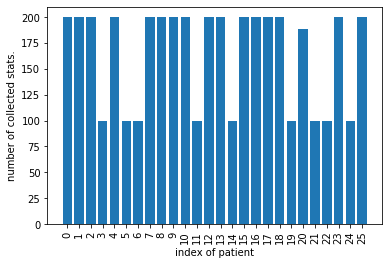

self.num_calls_to_getflagfinished = 29

 numstats in [100 , 200],     num zeros = 0


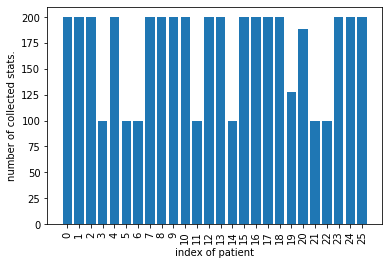

 got 70 stats
self.num_calls_to_getflagfinished = 30

 numstats in [100 , 200],     num zeros = 0


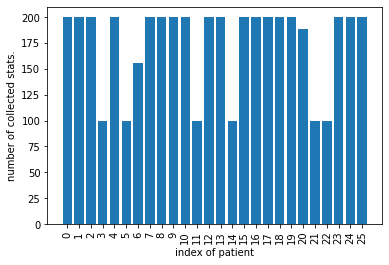

self.num_calls_to_getflagfinished = 31

 numstats in [100 , 200],     num zeros = 0


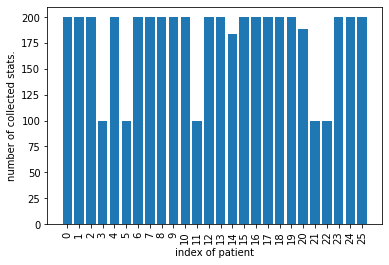

self.num_calls_to_getflagfinished = 32

 numstats in [100 , 200],     num zeros = 0


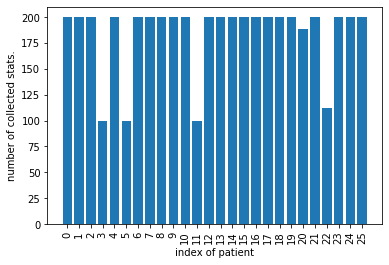

self.num_calls_to_getflagfinished = 33

 numstats in [100 , 200],     num zeros = 0


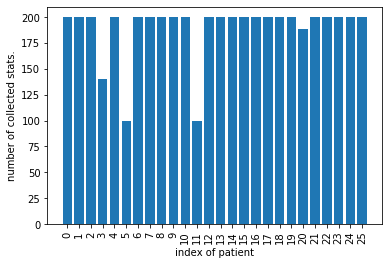

self.num_calls_to_getflagfinished = 34

 numstats in [100 , 200],     num zeros = 0


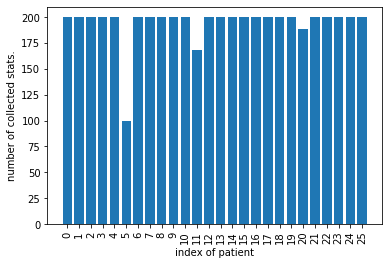

 got 80 stats
self.num_calls_to_getflagfinished = 35

 numstats in [188 , 200],     num zeros = 0


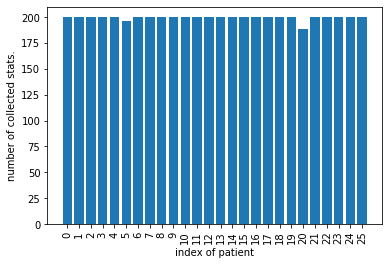

self.num_calls_to_getflagfinished = 36

 numstats in [200 , 288],     num zeros = 0


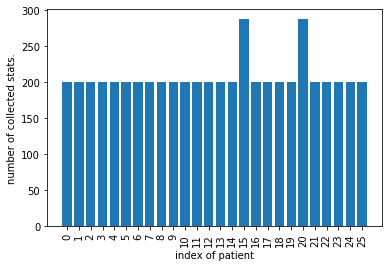

self.num_calls_to_getflagfinished = 37

 numstats in [200 , 300],     num zeros = 0


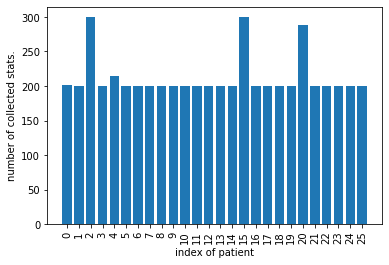

self.num_calls_to_getflagfinished = 38

 numstats in [200 , 300],     num zeros = 0


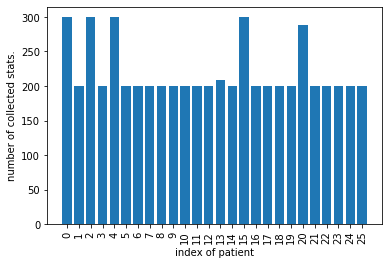

 got 90 stats
self.num_calls_to_getflagfinished = 39

 numstats in [200 , 300],     num zeros = 0


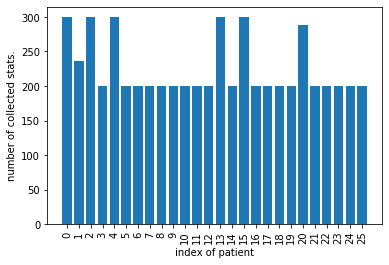

self.num_calls_to_getflagfinished = 40

 numstats in [200 , 300],     num zeros = 0


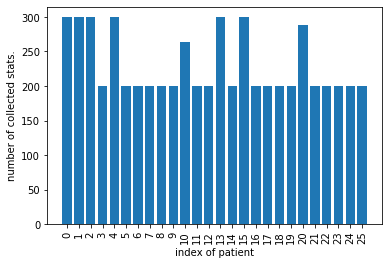

self.num_calls_to_getflagfinished = 41

 numstats in [200 , 300],     num zeros = 0


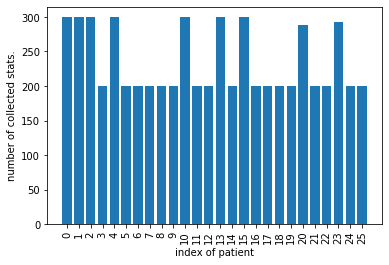

self.num_calls_to_getflagfinished = 42

 numstats in [200 , 300],     num zeros = 0


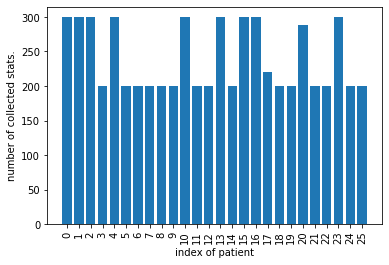

self.num_calls_to_getflagfinished = 43

 numstats in [200 , 300],     num zeros = 0


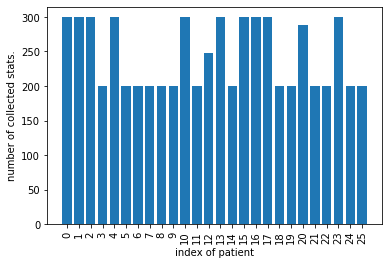

 got 100 stats
self.num_calls_to_getflagfinished = 44

 numstats in [200 , 300],     num zeros = 0


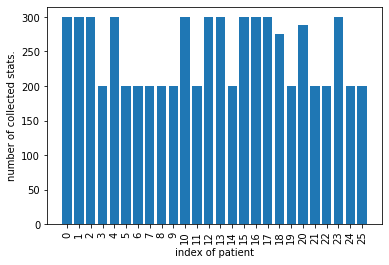

self.num_calls_to_getflagfinished = 45

 numstats in [200 , 300],     num zeros = 0


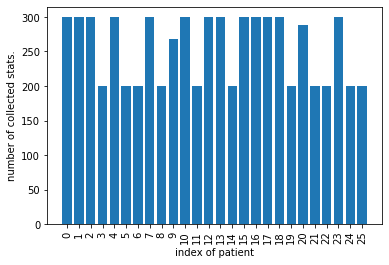

self.num_calls_to_getflagfinished = 46

 numstats in [200 , 300],     num zeros = 0


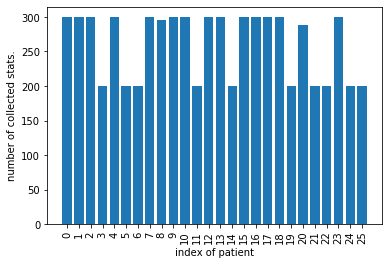

self.num_calls_to_getflagfinished = 47

 numstats in [200 , 300],     num zeros = 0


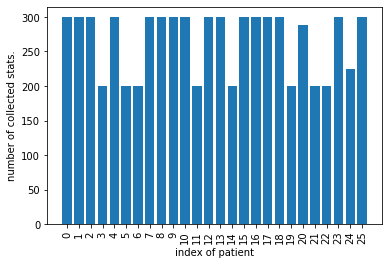

 got 110 stats
self.num_calls_to_getflagfinished = 48

 numstats in [200 , 300],     num zeros = 0


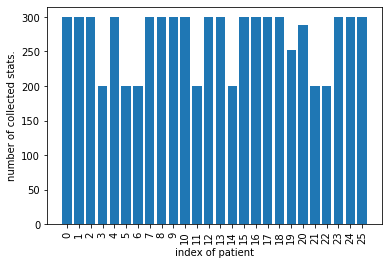

self.num_calls_to_getflagfinished = 49

 numstats in [200 , 300],     num zeros = 0


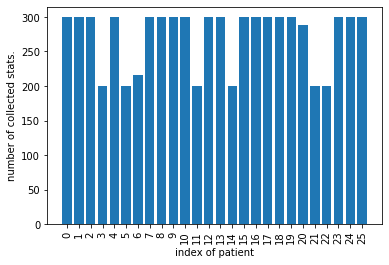

self.num_calls_to_getflagfinished = 50

 numstats in [200 , 300],     num zeros = 0


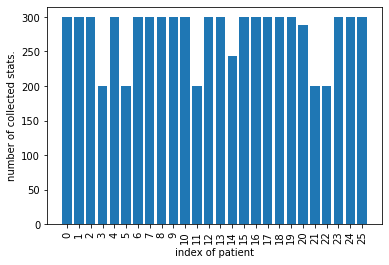

self.num_calls_to_getflagfinished = 51

 numstats in [200 , 300],     num zeros = 0


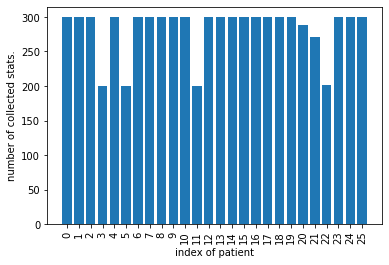

self.num_calls_to_getflagfinished = 52

 numstats in [200 , 300],     num zeros = 0


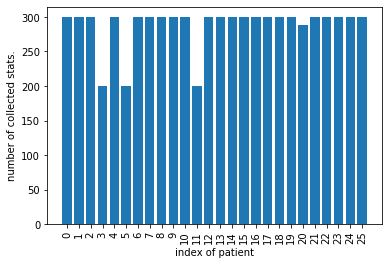

self.num_calls_to_getflagfinished = 53

 numstats in [200 , 300],     num zeros = 0


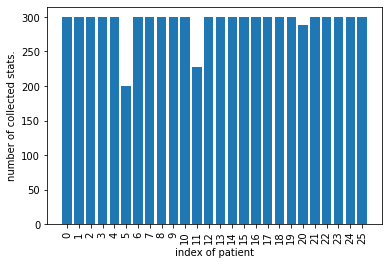

 got 120 stats
self.num_calls_to_getflagfinished = 54

 numstats in [239 , 305],     num zeros = 0


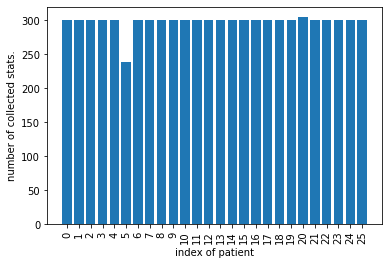

self.num_calls_to_getflagfinished = 55

 numstats in [300 , 388],     num zeros = 0


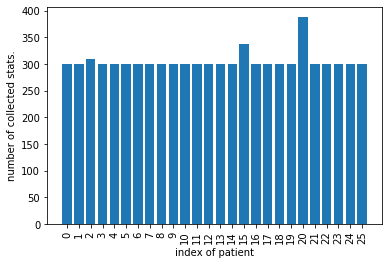

self.num_calls_to_getflagfinished = 56

 numstats in [300 , 400],     num zeros = 0


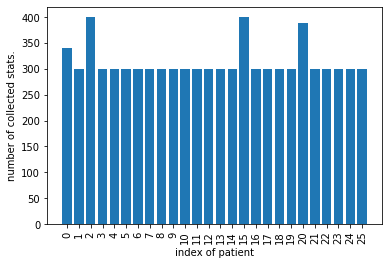

self.num_calls_to_getflagfinished = 57

 numstats in [300 , 400],     num zeros = 0


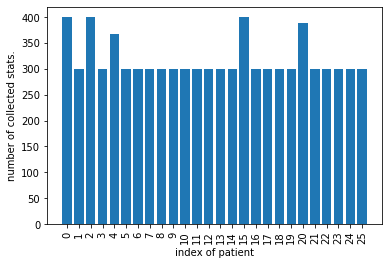

 got 130 stats
self.num_calls_to_getflagfinished = 58

 numstats in [300 , 400],     num zeros = 0


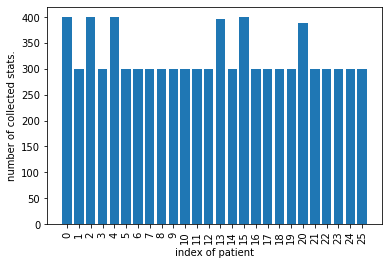

self.num_calls_to_getflagfinished = 59

 numstats in [300 , 400],     num zeros = 0


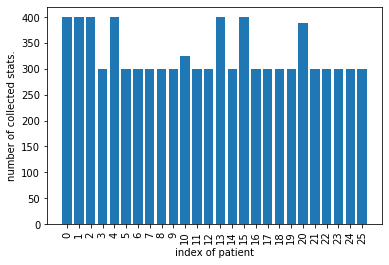

self.num_calls_to_getflagfinished = 60

 numstats in [300 , 400],     num zeros = 0


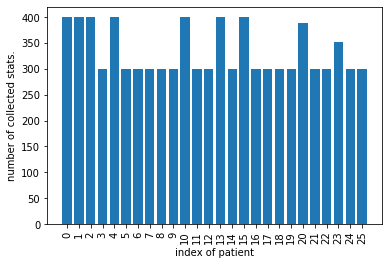

self.num_calls_to_getflagfinished = 61

 numstats in [300 , 400],     num zeros = 0


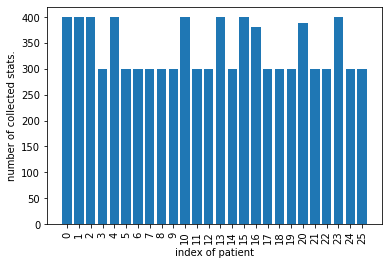

self.num_calls_to_getflagfinished = 62

 numstats in [300 , 400],     num zeros = 0


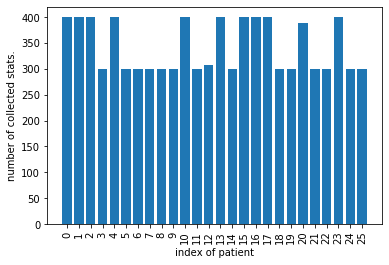

 got 140 stats
self.num_calls_to_getflagfinished = 63

 numstats in [300 , 400],     num zeros = 0


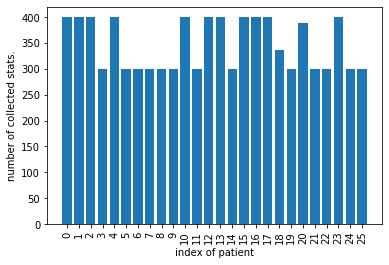

self.num_calls_to_getflagfinished = 64

 numstats in [300 , 400],     num zeros = 0


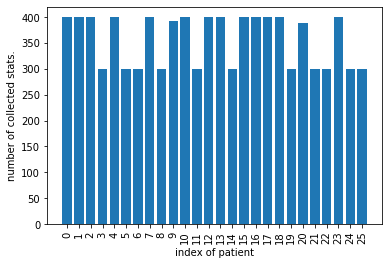

self.num_calls_to_getflagfinished = 65

 numstats in [300 , 400],     num zeros = 0


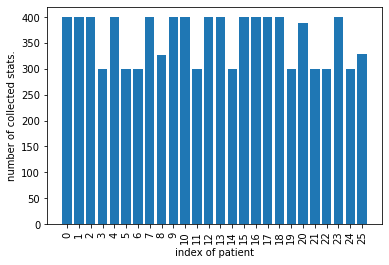

self.num_calls_to_getflagfinished = 66

 numstats in [300 , 400],     num zeros = 0


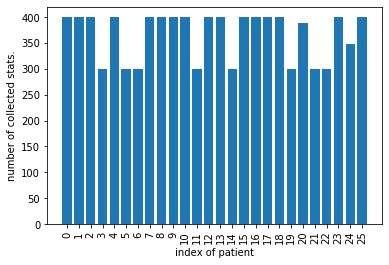

 got 150 stats
self.num_calls_to_getflagfinished = 67

 numstats in [300 , 400],     num zeros = 0


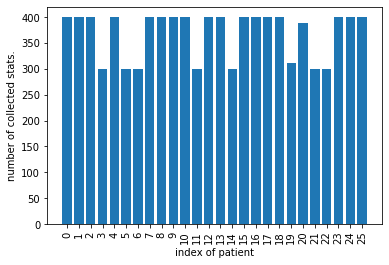

self.num_calls_to_getflagfinished = 68

 numstats in [300 , 400],     num zeros = 0


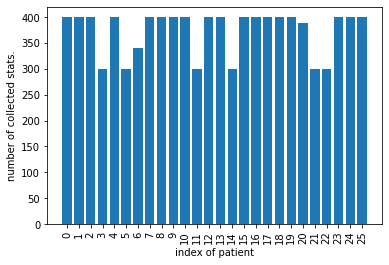

self.num_calls_to_getflagfinished = 69

 numstats in [300 , 400],     num zeros = 0


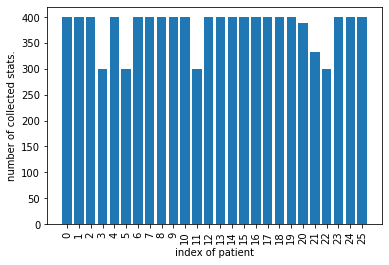

self.num_calls_to_getflagfinished = 70

 numstats in [300 , 400],     num zeros = 0


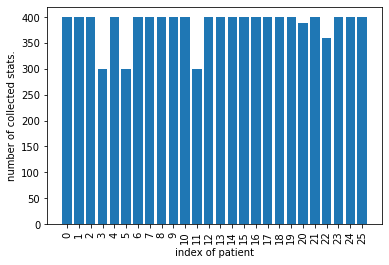

self.num_calls_to_getflagfinished = 71

 numstats in [300 , 400],     num zeros = 0


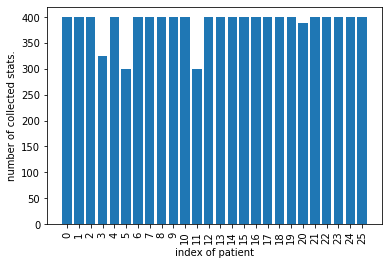

 got 160 stats
self.num_calls_to_getflagfinished = 72

 numstats in [300 , 400],     num zeros = 0


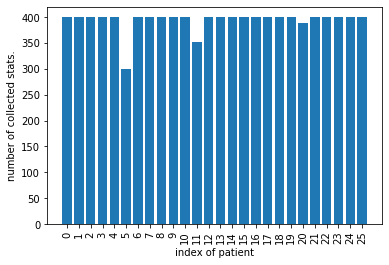

self.num_calls_to_getflagfinished = 73

 numstats in [380 , 400],     num zeros = 0


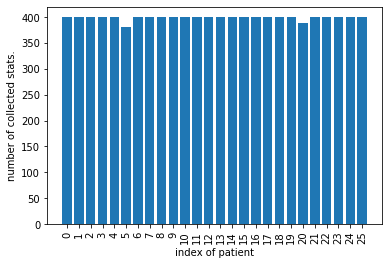

self.num_calls_to_getflagfinished = 74

 numstats in [400 , 488],     num zeros = 0


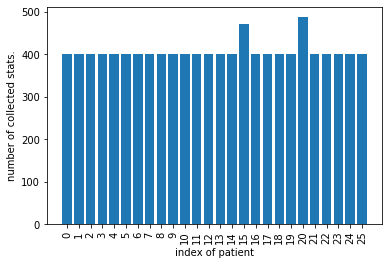

self.num_calls_to_getflagfinished = 75

 numstats in [400 , 500],     num zeros = 0


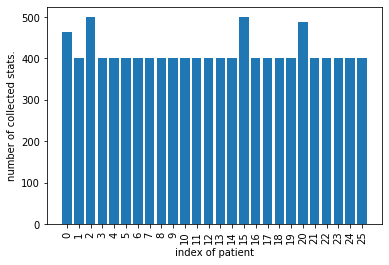

 got 170 stats
self.num_calls_to_getflagfinished = 76

 numstats in [400 , 500],     num zeros = 0


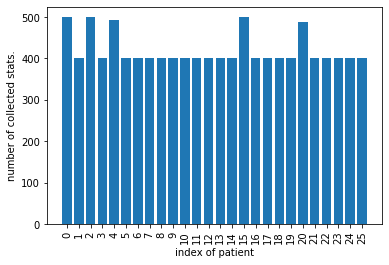

self.num_calls_to_getflagfinished = 77

 numstats in [400 , 500],     num zeros = 0


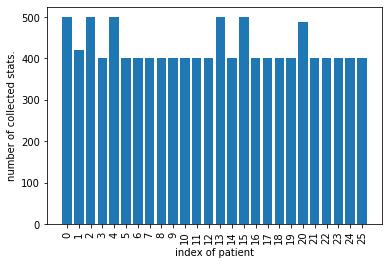

self.num_calls_to_getflagfinished = 78

 numstats in [400 , 500],     num zeros = 0


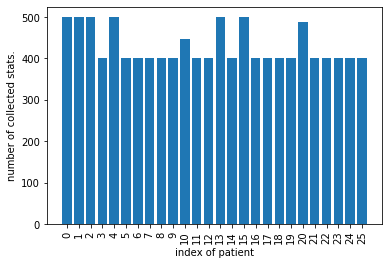

self.num_calls_to_getflagfinished = 79

 numstats in [400 , 500],     num zeros = 0


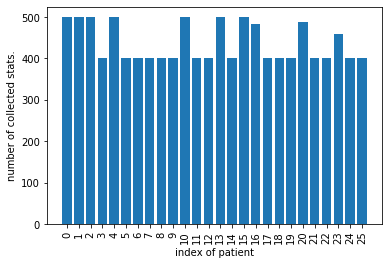

self.num_calls_to_getflagfinished = 80

 numstats in [400 , 500],     num zeros = 0


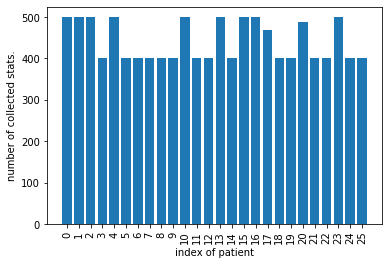

 got 180 stats
self.num_calls_to_getflagfinished = 81

 numstats in [400 , 500],     num zeros = 0


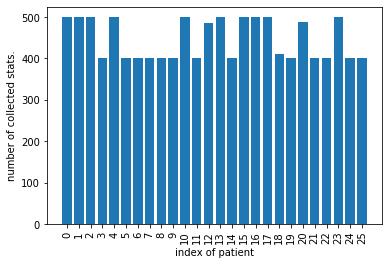

self.num_calls_to_getflagfinished = 82

 numstats in [400 , 500],     num zeros = 0


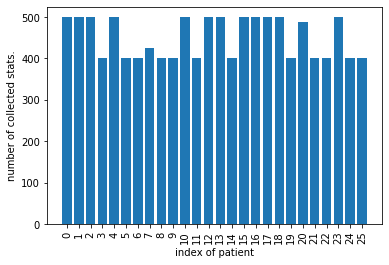

self.num_calls_to_getflagfinished = 83

 numstats in [400 , 500],     num zeros = 0


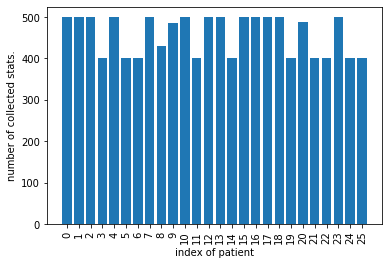

self.num_calls_to_getflagfinished = 84

 numstats in [400 , 500],     num zeros = 0


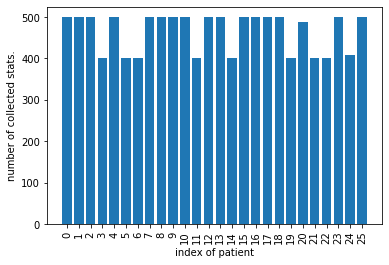

 got 190 stats
self.num_calls_to_getflagfinished = 85

 numstats in [400 , 500],     num zeros = 0


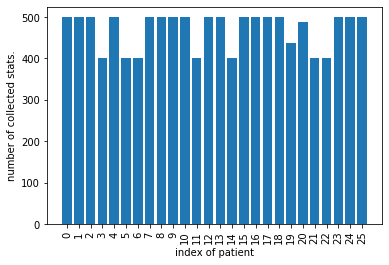

self.num_calls_to_getflagfinished = 86

 numstats in [400 , 500],     num zeros = 0


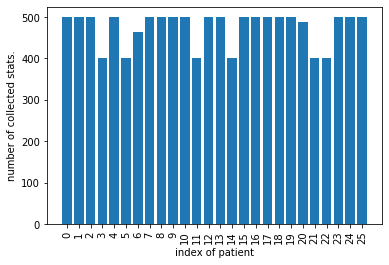

self.num_calls_to_getflagfinished = 87

 numstats in [400 , 500],     num zeros = 0


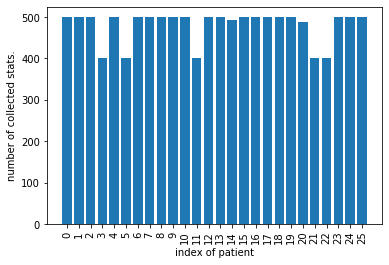

self.num_calls_to_getflagfinished = 88

 numstats in [400 , 500],     num zeros = 0


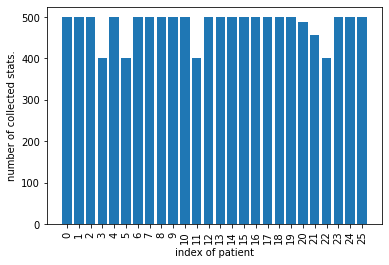

self.num_calls_to_getflagfinished = 89

 numstats in [400 , 500],     num zeros = 0


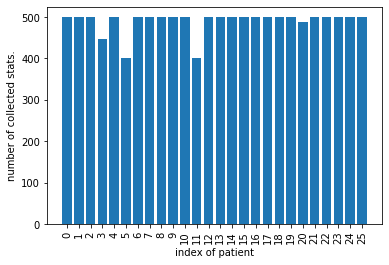

 got 200 stats
self.num_calls_to_getflagfinished = 90

 numstats in [400 , 500],     num zeros = 0


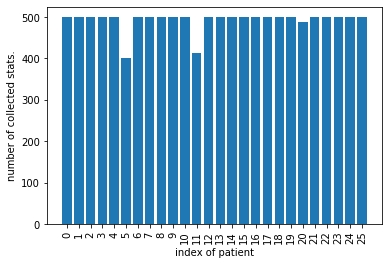

self.num_calls_to_getflagfinished = 91

 numstats in [440 , 500],     num zeros = 0


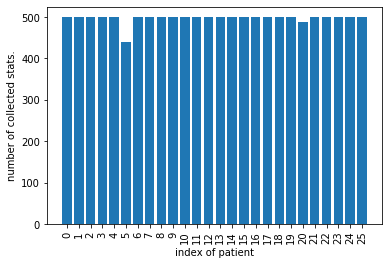

self.num_calls_to_getflagfinished = 92

 numstats in [500 , 500],     num zeros = 0


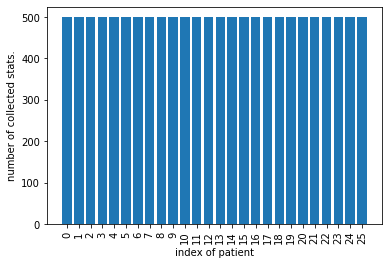

In [10]:
statcollector.start()

In [11]:
time.sleep(10) #to make sure that the data from subprocesses is transmitted
dict_patient_to_stats = statcollector.get_finalstats()

In [ ]:
#compute dict_patient_to_avgencodeddescriptor ====================
dict_patient_to_avgencodeddescriptor = {}
for patient in dict_patient_to_stats.keys():
    if(dict_patient_to_stats[patient] != None):
#         print(dict_patient_to_stats[patient]["sum_encoded_descriptors"].shape)
        avgh_of_patient = dict_patient_to_stats[patient]["sum_encoded_descriptors"]
                #[200 x 14 x 14]
        avgh_of_patient = np.sum(avgh_of_patient, 1) #[200x14]
        avgh_of_patient = np.sum(avgh_of_patient, 1) #[200]
        avgh_of_patient = avgh_of_patient / dict_patient_to_stats[patient]["count"]
        avgh_of_patient = avgh_of_patient/\
                    (dict_patient_to_stats[patient]["sum_encoded_descriptors"].shape[1]*\
                     dict_patient_to_stats[patient]["sum_encoded_descriptors"].shape[2])
        dict_patient_to_avgencodeddescriptor[patient] = avgh_of_patient
    else:
        dict_patient_to_avgencodeddescriptor[patient] = None

#comput dict_patient_to_prob ========
dict_patient_to_prob = {}
for patient in dict_patient_to_stats.keys():
    if(dict_patient_to_stats[patient] != None):
        avgh_of_patient = dict_patient_to_avgencodeddescriptor[patient] #[100]
        with torch.no_grad():
            tensor_hofpatient = torch.from_numpy(avgh_of_patient).float()\
                                .unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
            prob_of_patient = model.module_stg4(tensor_hofpatient).cpu().numpy()[:,:,0,0]
            dict_patient_to_prob[patient] = prob_of_patient
            

In [ ]:
print(tensor_hofpatient.shape)

In [ ]:
all_probs, all_recscore, all_color = [], [], []
for patient in dict_patient_to_prob.keys():
    all_probs.append(dict_patient_to_prob[patient].flatten())
    all_recscore.append(float(patient.dict_records["rs"]))
    if(float(patient.dict_records["rs"]) > 25.5):
        all_color.append('r')
    else:
        all_color.append('b')
all_probs = np.array(all_probs)
xy_noise = np.random.randn(all_probs.shape[0], all_probs.shape[1])*0.01
print(all_probs)
# all_probs = scipy.special.softmax(all_probs)
plt.figure(figsize=(10,8))
plt.scatter(all_probs[:,0]+xy_noise[:,0],
            all_probs[:,1]+xy_noise[:,1],
            s=20, c=all_recscore, cmap="jet")
plt.colorbar()
plt.show()
plt.figure(figsize=(8,8))
plt.scatter(all_probs[:,0],
            all_probs[:,1],
            s=20, c=all_color, cmap="jet")
plt.axis("equal")
plt.show()